# Projekt Algorytmy Eksploracji Danych

### Jakub Darul 1/1, Mateusz Lamla 1/1

##### Import potrzebnych bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from mlxtend.frequent_patterns import apriori, association_rules


### Wczytanie danych

In [2]:
df_2009_2010 = pd.read_excel('data\online_retail_II.xlsx')
df_2010_2011 = pd.read_excel('data\online_retail_II.xlsx', sheet_name='Year 2010-2011')
df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
C:\Users\mateuszlamla\AppData\Local\Temp\ipykernel_1264\949266689.py:1: SyntaxWarning: invalid escape sequence '\o'
  df_2009_2010 = pd.read_excel('data\online_retail_II.xlsx')
C:\Users\mateuszlamla\AppData\Local\Temp\ipykernel_1264\949266689.py:2: SyntaxWarning: invalid escape sequence '\o'
  df_2010_2011 = pd.read_excel('data\online_retail_II.xlsx', sheet_name='Year 2010-2011')
C:\Users\mateuszlamla\miniconda3\envs\SEMESTR5\Lib\site-packages\openpyxl\packaging\core.py:89: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  created=datetime.datetime.utcnow(),
C:\Users\mateuszlamla\miniconda3\envs\SEMESTR5\Lib\site-packages\openpyxl\packag

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Przygotowanie danych i wstępne testy

In [3]:
df = df.dropna()
df['Description'] = df['Description'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

customer_products = df.groupby('Customer ID')['Description'].apply(lambda x: ' '.join(x))

vectorizer = CountVectorizer(max_features=100, stop_words='english')
X_text = vectorizer.fit_transform(customer_products)

products_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())
customers_id = customer_products.index

In [4]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
df['TotalSum'] = df['Quantity'] * df['Price']
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSum': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [5]:
full_data = pd.concat([products_df.reset_index(), rfm[['Recency', 'Frequency', 'Monetary']]], axis=1)

##### Normalizacja danych

In [6]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(full_data)
df_scaled = pd.DataFrame(data_scaled, columns=full_data.columns)

##### Testy Bartletta i KMO

In [7]:
chi_square_value, p_value = calculate_bartlett_sphericity(df_scaled)

print(f"Statystyka Chi2: {chi_square_value:.2f}")
print(f"P-value: {p_value:.4e}")

Statystyka Chi2: 1090788.13
P-value: 0.0000e+00


In [8]:
kmo_all, kmo_model = calculate_kmo(df_scaled)

print(f"Wartość KMO (Total): {kmo_model:.3f}")

Wartość KMO (Total): 0.979


C:\Users\mateuszlamla\miniconda3\envs\SEMESTR5\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


### PCA

In [9]:
pca = PCA()
pca.fit(data_scaled)

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",None
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized S

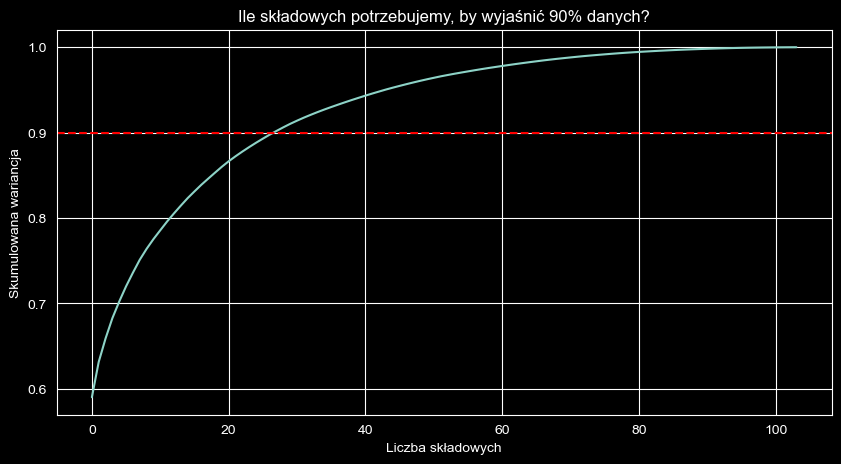

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Liczba składowych')
plt.ylabel('Skumulowana wariancja')
plt.title('Ile składowych potrzebujemy, by wyjaśnić 90% danych?')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [11]:
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(n_components)

28


In [12]:
pca_final = PCA(n_components=n_components)
data_pca = pca_final.fit_transform(data_scaled)

### K-Means

In [13]:
inertia = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)

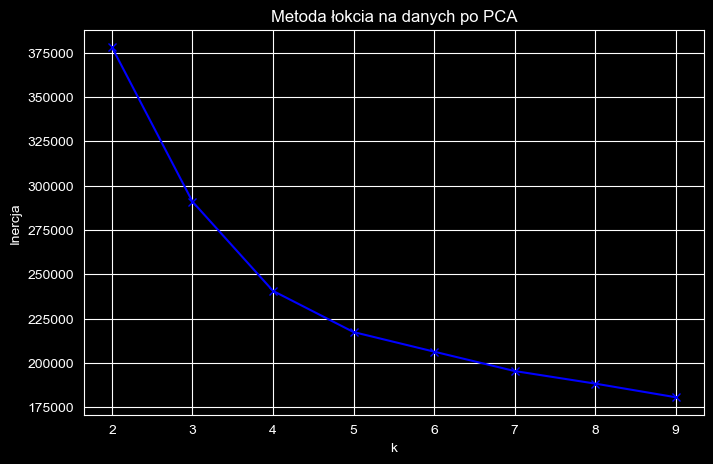

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inercja')
plt.title('Metoda łokcia na danych po PCA')
plt.show()

In [15]:
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=42)
clusters = kmeans.fit_predict(data_pca)

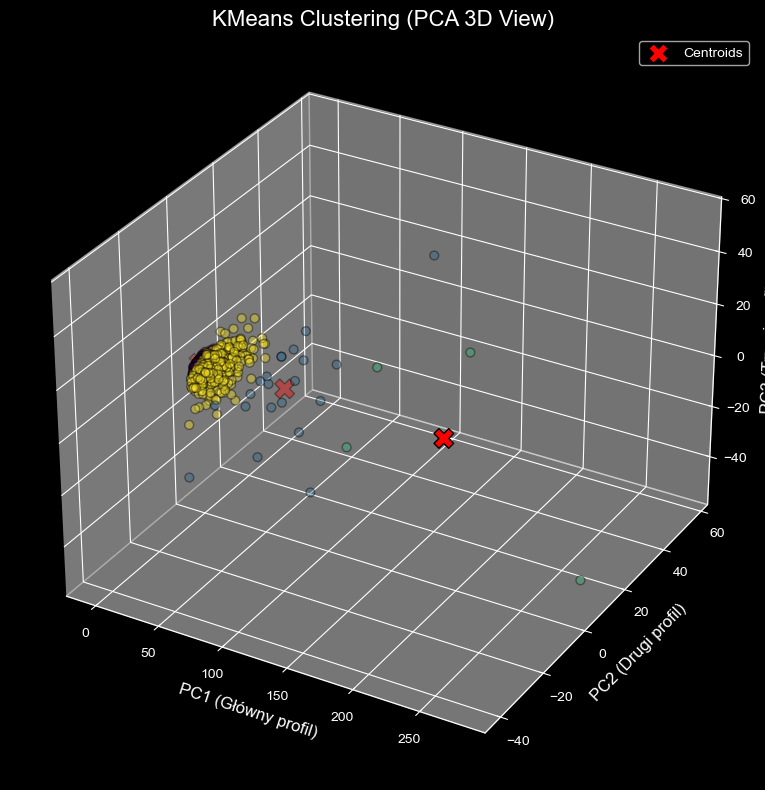

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection="3d")

scatter = ax.scatter(
    data_pca[:, 0],
    data_pca[:, 1],
    data_pca[:, 2],
    c=clusters,
    cmap='viridis',
    s=40,
    edgecolors="k",
    alpha=0.4
)

ax.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    kmeans.cluster_centers_[:, 2],
    c="red",
    marker="X",
    s=200,
    label="Centroids",
    edgecolors="k",
)

ax.set_title("KMeans Clustering (PCA 3D View)", fontsize=16)
ax.set_xlabel("PC1 (Główny profil)", fontsize=12)
ax.set_ylabel("PC2 (Drugi profil)", fontsize=12)
ax.set_zlabel("PC3 (Trzeci profil)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

##### Testy po zastosowaniu K-Means i PCA

In [17]:
silhouette_avg = silhouette_score(data_pca, clusters)
davies_bouldin = davies_bouldin_score(data_pca, clusters)
calinski_harabasz = calinski_harabasz_score(data_pca, clusters)

print(f"Silhouette Score: {silhouette_avg:.3f} (Im bliżej 1, tym lepsza separacja)")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f} (Im niżej, tym lepiej)")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f} (Im wyżej, tym lepiej)")

Silhouette Score: 0.664 (Im bliżej 1, tym lepsza separacja)
Davies-Bouldin Index: 1.168 (Im niżej, tym lepiej)
Calinski-Harabasz Index: 2476.731 (Im wyżej, tym lepiej)


##### RFM

            Recency   Frequency       Monetary
Cluster                                       
0        219.993494    4.986059    1478.379242
1         23.142857  103.428571   82254.530952
2          1.250000  355.750000  104957.307500
3         40.273743   26.919926   12192.621389


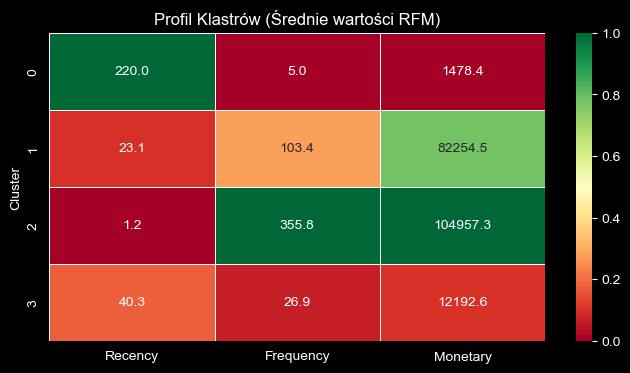

In [18]:
rfm['Cluster'] = clusters

cluster_means = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_means)

scaler_minmax = MinMaxScaler()
means_scaled = pd.DataFrame(scaler_minmax.fit_transform(cluster_means),
                          columns=cluster_means.columns,
                          index=cluster_means.index)

plt.figure(figsize=(8, 4))
sns.heatmap(means_scaled, annot=cluster_means, fmt=".1f", cmap="RdYlGn", linewidths=.5)
plt.title('Profil Klastrów (Średnie wartości RFM)')
plt.show()

### Reguły asocjacji - Apriori

In [20]:
basket_data = df[df['Country'] == 'France']

transactions = basket_data.groupby('Invoice')['Description'].apply(list).tolist()

print(f"Liczba transakcji: {len(transactions)}")
print(f"Przykładowa transakcja: {transactions[0][:3]}...")

Liczba transakcji: 738
Przykładowa transakcja: ['CHRISTMAS PUDDING TRINKET POT ', 'BAKING SET 9 PIECE RETROSPOT ', 'RETRO SPOT TEA SET CERAMIC 11 PC ']...


In [21]:
mlb = MultiLabelBinarizer()
encoded_data = mlb.fit_transform(transactions)
transactions_df = pd.DataFrame(encoded_data, columns=mlb.classes_)

In [22]:
minimum_support = 0.07
print(f"Szukanie zbiorów częstych (min_support={minimum_support})...")

frequent_itemsets = apriori(transactions_df, min_support=minimum_support, use_colnames=True)
print(f"Znaleziono {len(frequent_itemsets)} częstych zbiorów.")

Szukanie zbiorów częstych (min_support=0.07)...
Znaleziono 50 częstych zbiorów.


C:\Users\mateuszlamla\miniconda3\envs\SEMESTR5\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Generowanie reguł (min_confidence=0.5)...

Top 10 Reguł asocjacyjnych:
                                 antecedents  \
23             (SET/6 RED SPOTTY PAPER CUPS)   
22           (SET/6 RED SPOTTY PAPER PLATES)   
29  (POSTAGE, SET/6 RED SPOTTY PAPER PLATES)   
33             (SET/6 RED SPOTTY PAPER CUPS)   
30    (POSTAGE, SET/6 RED SPOTTY PAPER CUPS)   
32           (SET/6 RED SPOTTY PAPER PLATES)   
8                 (PLASTERS IN TIN SPACEBOY)   
7         (PLASTERS IN TIN WOODLAND ANIMALS)   
2                 (PLASTERS IN TIN SPACEBOY)   
3           (PLASTERS IN TIN CIRCUS PARADE )   

                                 consequents   support  confidence      lift  
23           (SET/6 RED SPOTTY PAPER PLATES)  0.098916    0.839080  7.740517  
22             (SET/6 RED SPOTTY PAPER CUPS)  0.098916    0.912500  7.740517  
29             (SET/6 RED SPOTTY PAPER CUPS)  0.082656    0.897059  7.609533  
33  (POSTAGE, SET/6 RED SPOTTY PAPER PLATES)  0.082656    0.701149  7.609533  
30   

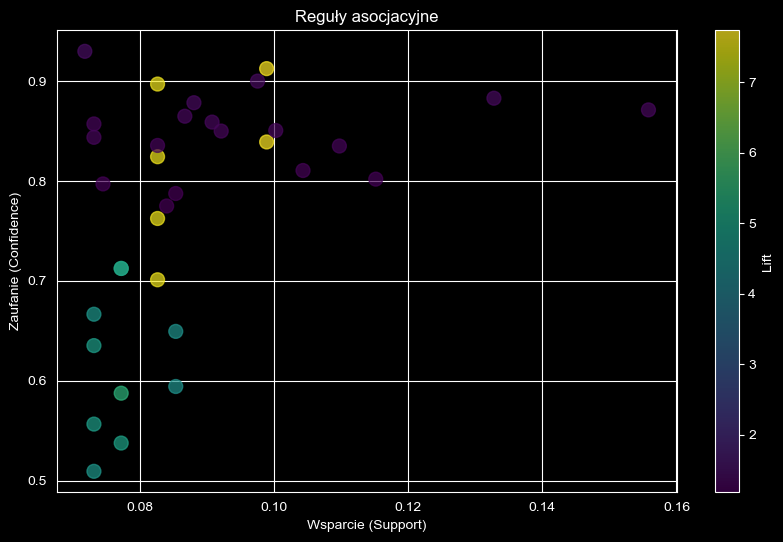

In [27]:
minimum_confidence = 0.5
print(f"Generowanie reguł (min_confidence={minimum_confidence})...")

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=minimum_confidence)

rules = rules.sort_values(['lift', 'confidence'], ascending=[False, False])

print("\nTop 10 Reguł asocjacyjnych:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(rules['support'], rules['confidence'],
                      c=rules['lift'], cmap='viridis', alpha=0.7, s=100)
plt.colorbar(scatter, label='Lift')
plt.xlabel('Wsparcie (Support)')
plt.ylabel('Zaufanie (Confidence)')
plt.title(f'Reguły asocjacyjne')
plt.grid(True)
plt.show()